In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing
from sklearn import metrics
from skimage.color import gray2rgb, rgb2gray # since the code wants color images
from sklearn.linear_model import Ridge, lars_path, LinearRegression
from skimage.util.montage import montage2d # to make a nice montage of the images
import pandas as pan

In [2]:
pictures = pan.read_csv("fer2013/fer2013.csv")
y_vec = pictures.emotion.astype(np.uint8)-3;
X_vec= np.stack([gray2rgb(np.asarray([map(int, x) for x in [pixel.split(' ')]]).reshape(( 48, 48))/256.0) for pixel in pictures.pixels
          ],0)#pixel

(-0.5, 479.5, 479.5, -0.5)

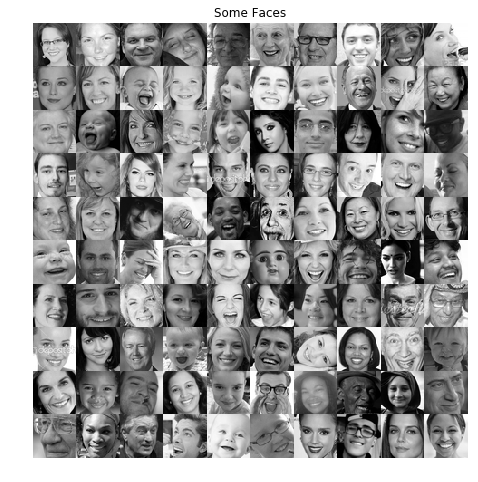

In [3]:
%matplotlib inline
#268#490
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
x=1
ax1.imshow(montage2d(X_vec[0:100,:,:,0]), cmap='gray', interpolation = 'none')
ax1.set_title('Some Faces')
ax1.axis('off')

In [52]:
def influenceToColorpicture(coefs):
    flatter  = max(max(coefs.flatten()),abs(min(coefs.flatten())))
    if flatter == 0:
        flatter = 1
    coefs = coefs/flatter;
    pos_coefs = np.copy(coefs)
    pos_coefs[pos_coefs<0] = 0
    pos_coefs = gray2rgb(pos_coefs)
    pos_coefs[:,:,0] = 1 - pos_coefs[:,:,0];
    pos_coefs[:,:,1] = 1 - pos_coefs[:,:,1];
    pos_coefs[:,:,2] = 1;
    neg_coefs = np.copy(coefs)
    neg_coefs[neg_coefs>0] = 0
    neg_coefs = gray2rgb(-neg_coefs);
    neg_coefs[:,:,0] = 1;
    neg_coefs[:,:,1] = 1 - neg_coefs[:,:,1];
    neg_coefs[:,:,2] = 1 - neg_coefs[:,:,2];
    new_coefs = neg_coefs+pos_coefs -1 
    return new_coefs

In [113]:
#Parameters 
# data   n*m array n = number of points m = dimension
# lables n array containing the classes
# number 0<number<n nuber of poi 
# kernel_width
# distance_metric 
def Lime(data, lables, number, kernel_width=0.25, distance_metric='euclidean',random_state=None, verbose=True):
    poi = data[number]
    labels_column = np.asarray(pan.get_dummies(lables))[:,lables[number]];
    distances = metrics.pairwise_distances(
            data,
            poi.reshape(1, -1),
           metric=distance_metric
        ).ravel();
    kernel_width = float(kernel_width)
    def kernel(d):
        return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))
    weights = kernel(distances);
    #model_regressor = Ridge(alpha=1, fit_intercept=True,
                                    random_state=random_state)
    model_regressor = LinearRegression()
    easy_model = model_regressor
    easy_model.fit(data, labels_column, sample_weight=weights)
    prediction_score = easy_model.score(
            data,
            labels_column, sample_weight=weights)
    local_pred = easy_model.predict(poi.reshape(1, -1))
    if verbose:
        print prediction_score
        print local_pred
    return {'prediction_score':prediction_score,'local_pred':local_pred,'coefs':easy_model.coef_.reshape(48,48)}

IndentationError: unexpected indent (<ipython-input-113-a5c940f17fdb>, line 20)

In [6]:
data = X_vec[:,:,:,0].flatten().reshape(len(y_vec),-1);
distance_metric = 'euclidean'

In [7]:
number = 268;
result = Lime(data,y_vec,number,kernel_width=3)

0.452162915234
[ 0.98852099]


(-0.5, 47.5, 47.5, -0.5)

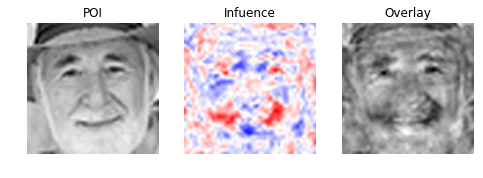

In [268]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (8,8))
ax1.imshow(data[number].reshape(48,48),cmap='gray',  interpolation = 'spline36')
ax1.set_title('POI')
ax1.axis('off')
ax2.imshow(influenceToColorpicture(result['coefs']),  interpolation = 'spline36')
ax2.set_title('Infuence')
ax2.axis('off')
ax3.imshow(data[number].reshape(48,48)+result['coefs']/max(max(result['coefs'].flatten()),-min(result['coefs'].flatten()),0.000001),cmap='gray',  interpolation = 'spline36')
ax3.set_title('Overlay')
ax3.axis('off')


In [269]:
with open('picture_out.png', 'wb') as f:
    f.write(influenceToColorpicture(result['coefs']))

In [270]:
plt.imsave('test.png', influenceToColorpicture(result['coefs']))

In [116]:
%%time
newpath ='LinearCosine'

for number in [0,26,268,469,490,13,10000,10001,10002,10003,10004]:
    if not os.path.exists(newpath+"\\"+str(number)):
        os.makedirs(newpath+"\\"+str(number))
    filepath = newpath+'\\'+str(number)+'\\'
    for kernel_width in np.arange(0.01, 0.05, 0.001):
        result = Lime(data,y_vec,number,kernel_width=kernel_width,distance_metric='cosine')
        kw = kernel_width;
        name = "kw%.3f_%d" % (kernel_width,number)
        plt.imsave(filepath+name+'Poi'+'.png', data[number].reshape(48,48),cmap='gray')
        plt.imsave(filepath+name+'Inf'+'.png', influenceToColorpicture(result['coefs']))
        plt.imsave(filepath+name+'Ov'+'.png', data[number].reshape(48,48)+result['coefs']/max(max(result['coefs'].flatten()),-min(result['coefs'].flatten())),cmap='gray')
newpath ='LinearEuclidean'
for number in [0,26,268,469,490,13,10000,10001,10002,10003,10004]:
    if not os.path.exists(newpath+"\\"+str(number)):
        os.makedirs(newpath+"\\"+str(number))
    filepath = newpath+'\\'+str(number)+'\\'
    for kernel_width in np.arange(0.1, 5, 0.05):
        result = Lime(data,y_vec,number,kernel_width=kernel_width)
        kw = kernel_width;
        name = "kw%.3f_%d" % (kernel_width,number)
        plt.imsave(filepath+name+'Poi'+'.png', data[number].reshape(48,48),cmap='gray')
        plt.imsave(filepath+name+'Inf'+'.png', influenceToColorpicture(result['coefs']))
        plt.imsave(filepath+name+'Ov'+'.png', data[number].reshape(48,48)+result['coefs']/max(max(result['coefs'].flatten()),-min(result['coefs'].flatten())),cmap='gray')

0.000146505987843
[ 0.99999888]
0.00157842134066
[ 0.99998794]
0.00957373923465
[ 0.99992667]
0.0382349308371
[ 0.99970462]
0.109869380453
[ 0.99913242]
0.238324055898
[ 0.99803626]
0.403973886082
[ 0.99645082]
0.558634267439
[ 0.99470374]
0.665771099123
[ 0.99320034]
0.720826036304
[ 0.99211931]
0.73633340493
[ 0.99138209]
0.726822096743
[ 0.99083098]
0.704180427072
[ 0.99032126]
0.676131073976
[ 0.98972438]
0.646814628698
[ 0.98894742]
0.618859051381
[ 0.9879577]
0.594570693601
[ 0.98677702]
0.575680342881
[ 0.98545262]
0.56267289631
[ 0.98403123]
0.554683401421
[ 0.98254765]
0.550071975471
[ 0.98102263]
0.547165068496
[ 0.97946446]
0.544726499211
[ 0.97787255]
0.542078354965
[ 0.97624161]
0.538998193472
[ 0.9745647]
0.535539842287
[ 0.97283458]
0.531871643484
[ 0.97104362]
0.52816934417
[ 0.96918315]
0.524563980374
[ 0.96724268]
0.521128990265
[ 0.96520959]
0.517888589862
[ 0.96306941]
0.514833727616
[ 0.96080646]
0.511937647187
[ 0.95840492]
0.5091677038
[ 0.95584969]
0.50649287380

0.157515852828
[ 0.99932103]
0.276431702968
[ 0.99841277]
0.367277168994
[ 0.99716969]
0.435367868862
[ 0.99573666]
0.477503981912
[ 0.99463267]
0.494186900684
[ 0.99429696]
0.493843498275
[ 0.99466224]
0.48593635616
[ 0.99540676]
0.477204961821
[ 0.99624501]
0.470792562778
[ 0.9970553]
0.467211904698
[ 0.99788976]
0.465882248863
[ 0.99889226]
0.466131662552
[ 1.00019362]
0.467482549184
[ 1.00184943]
0.46959061115
[ 1.00383701]
0.47215125506
[ 1.0060888]
0.474873093584
[ 1.0085304]
0.477498829598
[ 1.01110373]
0.479831658518
[ 1.0137721]
0.481745230295
[ 1.01651389]
0.483176511578
[ 1.01931225]
0.484109938305
[ 1.02214626]
0.484560819802
[ 1.0249857]
0.484562181457
[ 1.02778976]
0.48415592525
[ 1.03050879]
0.483387482542
[ 1.03308795]
0.482302733959
[ 1.03547145]
0.480946216286
[ 1.03760659]
0.479360025249
[ 1.03944697]
0.477583122817
[ 1.04095467]
0.475650923498
[ 1.04210138]
0.473595101908
[ 1.04286871]
0.471443581569
[ 1.0432477]
0.46922066525
[ 1.04323793]
0.466947266323
[ 1.042846

C:\Users\workshop\Anaconda2\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in divide


1.0
[ 1.]
1.0
[ 1.]
1.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
4.4408920985e-16
[ 1.]
2.33146835171e-14
[ 1.]
7.95252752539e-13
[ 1.]
1.66775482313e-11
[ 1.]
2.3321233833e-10
[ 1.]
2.32923258459e-09
[ 1.]
1.75531813529e-08
[ 1.]
1.04315377447e-07
[ 1.]
5.06689928348e-07
[ 1.]
2.07138604691e-06
[ 0.99999998]
7.30119697279e-06
[ 0.99999994]
2.26386377775e-05
[ 0.99999983]
6.27924753517e-05
[ 0.99999952]
0.00015800984719
[ 0.99999877]
0.00036504848925
[ 0.99999715]
0.000782161950259
[ 0.99999384]
0.0015677007278
[ 0.99998752]
0.00296104435045
[ 0.99997611]
0.00530361443077
[ 0.9999565]
0.00905670207922
[ 0.99992423]
0.0148115969432
[ 0.99987314]
0.0232854509573
[ 0.99979507]
0.0352922614037
[ 0.99967966]
0.0516708135893
[ 0.99951452]
0.0731410141216
[ 0.99928612]
0.100056905167
[ 0.99898195]
0.13205890681
[ 0.99859418]
0.167739206722
[ 0.99812435]
0.204592322229
[ 0.99758685]
0.239522264115
[ 0.997008]


0.0144018579851
[ 0.99982261]
0.0286186199646
[ 0.99964254]
0.0532894089048
[ 0.9993222]
0.092265797608
[ 0.99879512]
0.147027019154
[ 0.99800411]
0.213660336211
[ 0.99693851]
0.282359414969
[ 0.99566566]
0.341878129654
[ 0.99431971]
0.385642202691
[ 0.99304202]
0.413605153279
[ 0.99192039]
0.429476966676
[ 0.99097166]
0.43739702379
[ 0.99016354]
0.440396269537
[ 0.98944569]
0.440303113533
[ 0.98877178]
0.438151051047
[ 0.98810925]
0.434572915811
[ 0.98744048]
0.430041061586
[ 0.98675931]
0.424967578571
[ 0.986066]
0.419718895003
[ 0.98536298]
0.414597232508
[ 0.98465261]
0.409823964199
[ 0.98393667]
0.405538694807
[ 0.98321713]
0.401811895807
[ 0.9824972]
0.398662715833
[ 0.98178198]
0.396075211427
[ 0.98107853]
0.394010530448
[ 0.98039537]
0.392415606768
[ 0.97974159]
0.391229714232
[ 0.97912573]
0.390389716244
[ 0.9785546]
0.389834199945
[ 0.97803243]
0.389506425858
[ 0.97756013]
0.389356096594
[ 0.97713503]
0.389340109677
[ 0.97675088]
0.389422554573
[ 0.97639825]
0.38957421753
[ 0

0.466547144669
[ 0.95918271]
0.465733977659
[ 0.95676571]
0.464814556246
[ 0.95419806]
0.463827052997
[ 0.95148635]
0.462800990283
[ 0.9486394]
0.461758518291
[ 0.945668]
0.460715720806
[ 0.94258464]
0.459683829583
[ 0.93940321]
0.458670287933
[ 0.93613869]
0.457679641657
[ 0.93280675]
0.456714259531
[ 0.92942341]
0.455774900252
[ 0.9260046]
0.454861150104
[ 0.92256579]
0.453971757588
[ 0.91912161]
0.453104889315
[ 0.91568555]
0.452258327527
[ 0.91226971]
0.451429624805
[ 0.90888454]
0.450616226996
[ 0.90553874]
0.449815571678
[ 0.90223914]
0.449025166771
[ 0.89899071]
0.448242652133
[ 0.89579657]
0.447465846067
[ 0.89265807]
0.446692778228
[ 0.88957499]
0.44592171033
[ 0.88654561]
0.445151146169
[ 0.88356703]
0.444379832526
[ 0.88063529]
0.443606752648
[ 0.87774567]
0.442831113936
[ 0.8748929]
0.442052331472
[ 0.87207135]
0.441270008803
[ 0.86927529]
0.440483917258
[ 0.86649902]
0.439693974866
[ 0.86373708]
0.438900225673
[ 0.86098433]
0.438102820112
[ 0.85823609]
0.437301996814
[ 0.8

0.386484397163
[ 0.9487584]
0.386565932571
[ 0.94705795]
0.386646898266
[ 0.94533614]
0.386724634981
[ 0.94358916]
0.386796930452
[ 0.94181326]
0.38686196043
[ 0.94000488]
0.386918239411
[ 0.93816063]
0.386964578754
[ 0.93627737]
0.387000050446
[ 0.9343522]
0.387023955323
[ 0.93238257]
0.387035794875
[ 0.9303662]
0.387035246023
[ 0.92830118]
0.387022138443
[ 0.92618597]
0.386996434136
[ 0.92401935]
0.386958208996
[ 0.92180051]
1.0
[ 1.]
1.0
[ 1.]
1.0
[ 1.]
1.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
0.0
[ 1.]
3.33066907388e-16
[ 1.]
2.79776202206e-14
[ 1.]
1.11777254119e-12
[ 1.]
2.63378208132e-11
[ 1.]
4.06895961369e-10
[ 1.]
4.46251691155e-09
[ 1.]
3.69521678811e-08
[ 1.]
2.42370575054e-07
[ 1.]
1.30726153358e-06
[ 0.99999998]
5.97174386863e-06
[ 0.9999999]
2.36543973565e-05
[ 0.9999996]
8.28031574664e-05
[ 0.99999863]
0.00026016247731
[ 0.99999575]
0.000743063599626
[ 0.99998805]
0.00194920779018
[ 0.99996919]
0.00473

In [9]:
import math

class Alpha1(object):
    def __call__(self, arg):
        return arg
    
class Alpha2(object):
    def __call__(self, arg):
        return arg*arg
    
class Alpha3(object):
    def __call__(self, arg):
        return math.exp(arg)

"""
Call Mim(Alpha2()) to get an MIM with alpha(x) = x^-2.
Add alphas above if you want to use different ones.

So to get the MIM (Alpha2) influence of any point of interest (poi) in a given dataset,
you can call Mim(Alpha2())(poi,dataset). poi is a list, and dataset is a list of
lists.

THE LAST ELEMENT OF ANY DATAPOINT IS THE LABEL.
"""

class Mim(object):
    
    def __init__(self, alpha):
        self._alpha = alpha
    
    def __call__(self, poi, dataset):
        inf_vec = []
        n = len(poi)-1
        for _ in range(n):
            inf_vec += [0]
        for y in dataset:
            diff = []
            sqsum = 0
            for i in range(n):
                diff+=[y[i]-poi[i]]
                sqsum+=(y[i]-poi[i])**2
            dist = math.sqrt(sqsum)
            if dist!=0:
                if poi[-1]==y[-1]:
                    for i in range(n):
                        inf_vec[i]+=diff[i]*1.0/self._alpha(dist)
                else:
                    for i in range(n):
                        inf_vec[i]-=diff[i]*1.0/self._alpha(dist)
        return inf_vec
    
#example
if __name__ == "__main__":
    dataset = [[0,0,0],[2,1,0],[0,1,1]]
    print(Mim(Alpha2())(dataset[0],dataset))

[0.3999999999999999, -0.8]


In [11]:
mimData = np.c_[data, y_vec]
number = 268 
x = np.asarray(Mim(Alpha2())(mimData[number],mimData)).reshape(48,48)

(-0.5, 47.5, 47.5, -0.5)

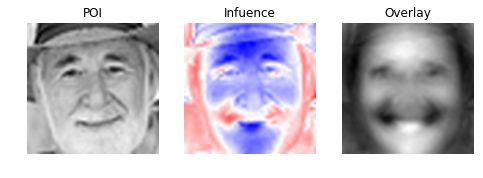

In [280]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (8,8))
ax1.imshow(data[number].reshape(48,48),cmap='gray',  interpolation = 'spline36')
ax1.set_title('POI')
ax1.axis('off')
ax2.imshow(influenceToColorpicture(x),  interpolation = 'spline36')
ax2.set_title('Infuence')
ax2.axis('off')
ax3.imshow(data[number].reshape(48,48)+x/max(max(x.flatten()),-min(x.flatten())),cmap='gray',  interpolation = 'spline36')
ax3.set_title('Overlay')
ax3.axis('off')

In [16]:
%%time
newpath ='MimAlpha2NewDataSet'
for number in [0,26,268,469,490,13,10000,10001,10002,10003,10004]:
    if not os.path.exists(newpath+str(number)):
        os.makedirs(newpath+str(number))
    result = np.asarray(Mim(Alpha2())(mimData[number],mimData)).reshape(48,48)
    name = "MIM"
    plt.imsave(newpath+str(number)+'\\'+name+'Poi'+'.png', data[number].reshape(48,48),cmap='gray')
    plt.imsave(newpath+str(number)+'\\'+name+'Inf'+'.png', influenceToColorpicture(result))
    plt.imsave(newpath+str(number)+'\\'+name+'Ov'+'.png', data[number].reshape(48,48)+result/max(max(result.flatten()),-min(result.flatten())),cmap='gray')
newpath ='MimAlpha1NewDataSet'
for number in [0,26,268,469,490,13,10000,10001,10002,10003,10004]:
    if not os.path.exists(newpath+str(number)):
        os.makedirs(newpath+str(number))
    result = np.asarray(Mim(Alpha1())(mimData[number],mimData)).reshape(48,48)
    name = "MIM"
    plt.imsave(newpath+str(number)+'\\'+name+'Poi'+'.png', data[number].reshape(48,48),cmap='gray')
    plt.imsave(newpath+str(number)+'\\'+name+'Inf'+'.png', influenceToColorpicture(result))
    plt.imsave(newpath+str(number)+'\\'+name+'Ov'+'.png', data[number].reshape(48,48)+result/max(max(result.flatten()),-min(result.flatten())),cmap='gray')
newpath ='MimAlpha3NewDataSet'
for number in [0,26,268,469,490,13,10000,10001,10002,10003,10004]:
    if not os.path.exists(newpath+str(number)):
        os.makedirs(newpath+str(number))
    result = np.asarray(Mim(Alpha3())(mimData[number],mimData)).reshape(48,48)
    name = "MIM"
    plt.imsave(newpath+str(number)+'\\'+name+'Poi'+'.png', data[number].reshape(48,48),cmap='gray')
    plt.imsave(newpath+str(number)+'\\'+name+'Inf'+'.png', influenceToColorpicture(result))
    plt.imsave(newpath+str(number)+'\\'+name+'Ov'+'.png', data[number].reshape(48,48)+result/max(max(result.flatten()),-min(result.flatten())),cmap='gray')


Wall time: 20min 19s


In [20]:
def alpha(dist,sigma=4.7):
    sqrt2pi = np.sqrt(2*np.pi)
    return np.exp(-0.5*(dist*dist)/(sigma*sigma))/(sigma*sqrt2pi)

In [21]:
alpha(2)

0.077533921065246647

In [72]:
def parzen(data, lables, number, sigma=4.7, distance_metric='euclidean',random_state=None, verbose=True):
    def alpha(dist):
        sqrt2pi = np.sqrt(2*np.pi)
        return np.exp(-0.5*(dist*dist)/(sigma*sigma))/(sigma*sqrt2pi)
    poi = data[number];
    poi_label = lables[number];
    distances = metrics.pairwise_distances(
            data,
            poi.reshape(1, -1),
           metric=distance_metric
    ).ravel();
    totalSum = sum(alpha(distances))
    equalSum = sum(alpha(distances[lables == poi_label]))
    nonequalSum = sum(alpha(distances[lables != poi_label]))
    weightedNonequalSum = np.zeros(np.shape(poi))
    weightedEqualSum = np.zeros(np.shape(poi))
    for y in range(len(data)):
        if lables[y] == poi_label:
            weightedEqualSum = weightedEqualSum + alpha(distances[y])*(data[y]-poi)
        else:
            weightedNonequalSum = weightedNonequalSum + alpha(distances[y])*(data[y]-poi)
    return (weightedEqualSum*nonequalSum-weightedNonequalSum*equalSum)/(sigma ** 2 * totalSum ** 2)
              
        
        

In [79]:
number = 490;
x = parzen(data,y_vec,number).reshape(48,48)

In [112]:
%%time
number = 268
newpath ='ParzenParametersCosine'
for sigma in  np.arange(0.01, 0.05, 0.001):
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    result = parzen(data,y_vec,268,sigma=sigma,distance_metric='cosine').reshape(48,48)
    name = "Parzen"+str(sigma)
    plt.imsave(newpath+'\\'+name+'Poi'+'.png', data[number].reshape(48,48),cmap='gray')
    plt.imsave(newpath+'\\'+name+'Inf'+'.png', influenceToColorpicture(result))
    plt.imsave(newpath+'\\'+name+'Ov'+'.png', data[number].reshape(48,48)+result/max(max(result.flatten()),-min(result.flatten())),cmap='gray')
newpath ='MimAlpha1NewDataSet'

Wall time: 22.2 s


(-0.5, 47.5, 47.5, -0.5)

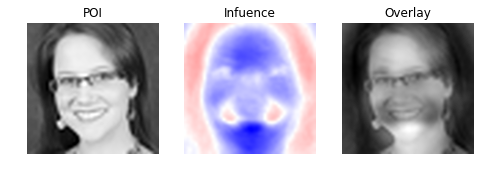

In [109]:
number = 0 
x = parzen(data,y_vec,number,sigma=6).reshape(48,48)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (8,8))
ax1.imshow(data[number].reshape(48,48),cmap='gray',  interpolation = 'spline36')
ax1.set_title('POI')
ax1.axis('off')
ax2.imshow(influenceToColorpicture(x),  interpolation = 'spline36')
ax2.set_title('Infuence')
ax2.axis('off')
ax3.imshow(data[number].reshape(48,48)+x/max(max(x.flatten()),-min(x.flatten())),cmap='gray',  interpolation = 'spline36')
ax3.set_title('Overlay')
ax3.axis('off')